In [1]:
from google.colab import drive 
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os 
os.chdir("/content/drive/My Drive/Poly AI/blog/")

In [3]:
!ls

test  train


<h1 style="font-weight: bold;font-size: 2.5em;text-align:center">Transfer Learning Basics</h1>





In [3]:
import os
import os.path as osp
import re
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2 

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [17]:
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import MSELoss, Linear, ReLU, Sigmoid, Module, BCELoss
from torch.optim import SGD, Adam
import torchvision
from torchvision import datasets, models, transforms
from torch import optim
from torchvision.datasets import CIFAR10

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Dataset Preparation

In [6]:
# Transforming image for pre-trained model
compose = transforms.Compose([
     transforms.Resize((224,224)),  # Required shape
     transforms.ToTensor()          # Image to tensor
])

train_data = CIFAR10('train/', train=True, download=True, transform=compose)
test_data = CIFAR10('test/', train=False, download=True, transform=compose)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# The 10 categories of CIFAR-10
categs = set()
for i, data in enumerate(test_data):
  categs.add(data[1])

categs 

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Referring the original 
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) 
dataset, we can find the correct categories to map

In [8]:
categories = ['airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship', 
'truck'
]

categ_map = {i:cat for i,cat in enumerate(categories)}
categ_map

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Visualizing the categories with images to verify if the class orders are correct.

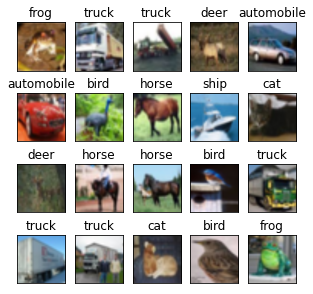

In [9]:
# Creating transform for image to 
img_transform = transforms.ToPILImage()

# Plotting train data's first 20 samples
fig = plt.figure(figsize=(5,5))

for i in range(20):
  imgTen, categ = train_data[i]
  img = img_transform(imgTen)

  ax = plt.subplot(4,5,i+1)
  ax.imshow(img)
  ax.set_title(categ_map[categ])
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False);

# Data Processing

## Custom Dataset

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    'Generates data for PyTorch'
    def __init__(self, folder):
        self.folder = folder
        self.files = os.listdir(self.folder)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
       
        file = self.files[index]

        # X
        image_loc = os.path.join(self.folder, file)
        image = cv2.imread(image_loc)
        image_tensor = torchvision.transforms.functional.to_tensor(image)
        # image_tensor.unsqueeze_(0)

        # Y
        file_ID = int(file[:-4])
        y = label_encoder.transform(train_df.loc[file_ID].values)
        y = torch.tensor(y[0])   # Target needs to be 1D. 
        # Achieved through the dataloader

        return image_tensor, y

In [ ]:
train_dataset = ImageDataset('train_anonimized')

In [ ]:
x, y = train_dataset.__getitem__(1)

## Dataloader

In [10]:
# Parameters
batch_size = 64
params = {
    'batch_size': batch_size,
    'shuffle': True,
    'num_workers': 6
  }
max_epochs = 100

train_loader = DataLoader(train_data, **params)
test_loader = DataLoader(test_data, **params)

# Training and eval

## Load pre-trained PyTorch models

In [11]:
# Load the pretrained model from pytorch

# Classification models trained on ImageNet dataset
Alexnet = models.alexnet(pretrained=True)
VGG = models.vgg13(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


### Model modification
The main work to customize the model to our requirements is to decide layers to be trained and those that are to be freezed. Also, we can customize certain layers of the pre-trained model.

Classification Layers

1. We want to train the classifier part of the model 
2. ImageNet had 1000 classes which we want to modify to 10 features for CIFAR-10

In [21]:
# Printing out the model structure
Alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
VGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [86]:
# Select the model
model = Alexnet
model = VGG

In [15]:
def alter_model(model, actions):
  if actions['freeze']:
    # 1. Freeze layers not to be trained 
    #    Thus, freezing all "features" layers
    for param in model.features.parameters():
        param.requires_grad = False

  # 2. Modify last classification layer
  n_inputs = model.classifier[6].in_features

  # add last linear layer (n_inputs -> 10 output classes)
  last_layer = nn.Linear(n_inputs, len(categ_map))

  model.classifier[6] = last_layer

  # check to see that your last layer produces the expected number of outputs
  print(model.classifier[6].out_features)

  return model.to(device)

VGG = alter_model(VGG, {'freeze': True})
Alexnet = alter_model(Alexnet, {'freeze': False})

10
10


## Training

In [23]:
criterion = nn.CrossEntropyLoss()

def train(model_details, n_epochs=10):
  model = model_details['model']
  name = model_details['name']
  
  optimizer = optim.SGD(model.classifier.parameters(), lr=0.0001, momentum=0)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  loss_list = []
  acc_list = []
  model.train()

  min_loss = np.inf

  for epoch in tqdm(range(1,1+n_epochs)):
    pred_list, target_list = [], []
    # scheduler.step()
    train_loss = 0
    for (data, target) in tqdm(train_loader):
      # data: (B, C, W, H)
      output = model(data.to(device))
      loss = criterion(output, target.to(device))
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      
      predictions = torch.max(output, dim=1).indices
      predictions = predictions.cpu().tolist()
      pred_list.extend(predictions)
      target_list.extend(target.cpu().tolist())

    if train_loss < min_loss:
      print('Saving model from epoch', epoch)
      torch.save(model, f'{name}.pth')
      min_loss = train_loss

    acc = accuracy_score(target_list, pred_list)
    print(f'Epoch: {epoch} => Accuracy: {acc:.6f}, Loss: {train_loss:.6f}\n')

    acc_list.append(acc)
    loss_list.append(train_loss)

  return acc_list, loss_list

In [24]:
n_epochs = 5

VGG_details = {'model': VGG, 'name': 'VGG'}
Alexnet_details = {'model': Alexnet, 'name': 'Alexnet'}

vggMetrics = train(VGG_details, n_epochs)


Saving model from epoch 1
Epoch: 1 => Accuracy: 0.738420, Loss: 605.462102




Saving model from epoch 2
Epoch: 2 => Accuracy: 0.777800, Loss: 517.530235




Saving model from epoch 3
Epoch: 3 => Accuracy: 0.803220, Loss: 458.000207




Epoch: 4 => Accuracy: 0.807940, Loss: 463.650999




Epoch: 5 => Accuracy: 0.808820, Loss: 470.348476




In [25]:
alexMetrics = train(Alexnet_details, n_epochs)


Saving model from epoch 1
Epoch: 1 => Accuracy: 0.547940, Loss: 1011.715323




Saving model from epoch 2
Epoch: 2 => Accuracy: 0.641460, Loss: 805.219091




Saving model from epoch 3
Epoch: 3 => Accuracy: 0.650000, Loss: 780.769768




Saving model from epoch 4
Epoch: 4 => Accuracy: 0.656220, Loss: 768.135970




Epoch: 5 => Accuracy: 0.657640, Loss: 771.734182




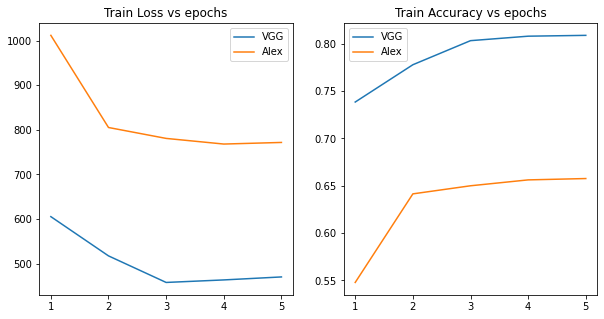

In [27]:
eps = [1+x for x in range(n_epochs)]
vgg_acc, vgg_loss = vggMetrics
alex_acc, alex_loss = alexMetrics

# Plotting metrics
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax[1].plot(eps, vgg_acc, label='VGG')
ax[1].plot(eps, alex_acc, label='Alex')
ax[1].set_title('Train Accuracy vs epochs')
ax[1].legend()

ax[0].plot(eps, vgg_loss, label='VGG')
ax[0].plot(eps, alex_loss, label='Alex')
ax[0].set_title('Train Loss vs epochs')
ax[0].legend()

plt.show()

## Evaluation

### Loading the best model for evaluation

In [12]:
PATH = 'VGG.pth'

In [13]:
model = torch.load(PATH)

### Metrics

In [31]:
from sklearn.metrics import classification_report

def evaluate(model):
  target_list, pred_list = [], []

  model.eval()
  with torch.no_grad():
    for (data, target) in tqdm(test_loader):
      output = model(data.to(device))
      predictions = torch.max(output, dim=1).indices
      predictions = predictions.cpu().tolist()
      pred_list.extend(predictions)
      target_list.extend(target.cpu().tolist())

  report = classification_report(target_list, pred_list, target_names=list(categ_map.values()))
  print(report)

In [33]:
vgg_best = torch.load('VGG.pth')
print('VGG')
evaluate(vgg_best)

print('-'*80)

alex_best = torch.load('Alexnet.pth')
print('Alexnet')
evaluate(alex_best)

VGG



              precision    recall  f1-score   support

    airplane       0.87      0.83      0.85      1000
  automobile       0.88      0.93      0.90      1000
        bird       0.80      0.66      0.72      1000
         cat       0.72      0.55      0.62      1000
        deer       0.64      0.85      0.73      1000
         dog       0.69      0.75      0.72      1000
        frog       0.72      0.92      0.81      1000
       horse       0.95      0.70      0.80      1000
        ship       0.90      0.87      0.88      1000
       truck       0.90      0.89      0.89      1000

    accuracy                           0.79     10000
   macro avg       0.81      0.79      0.79     10000
weighted avg       0.81      0.79      0.79     10000

--------------------------------------------------------------------------------
Alexnet



              precision    recall  f1-score   support

    airplane       0.62      0.88      0.73      1000
  automobile       0.90      0.79      0.84      1000
        bird       0.79      0.46      0.58      1000
         cat       0.71      0.25      0.37      1000
        deer       0.55      0.77      0.64      1000
         dog       0.54      0.76      0.63      1000
        frog       0.59      0.89      0.71      1000
       horse       0.89      0.65      0.75      1000
        ship       0.94      0.61      0.74      1000
       truck       0.81      0.86      0.83      1000

    accuracy                           0.69     10000
   macro avg       0.73      0.69      0.68     10000
weighted avg       0.73      0.69      0.68     10000



## Prediction

In [34]:
def predict(model, ind):
  imgTen, tgt = test_data[ind]
  x = imgTen.unsqueeze(0).to(device)
  out = model(x).cpu()
  pred = torch.max(out, axis=1).indices.tolist()

  pred = categ_map[pred[0]]
  tgt = categ_map[tgt]
  print(f'Prediction: {pred}, Actual: {tgt}\n')

  img = img_transform(imgTen)
  fig = plt.figure(figsize=(1,1))
  plt.imshow(img)
  plt.axis('off')
  plt.title(tgt)

Prediction: frog, Actual: frog



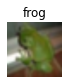

In [41]:
predict(vgg_best, 7)

Prediction: airplane, Actual: airplane



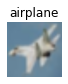

In [42]:
predict(vgg_best, 10)